### Importing Libraries

In [1]:
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd

#datavisualizations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm

#requests_cache to cache API call data
import requests_cache 
import time
from IPython.core.display import clear_output
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# keeping data from API calls into cache
requests_cache.install_cache()

### API Calls

While Loop over api.spacexdata (great API !) - over launch pages

Append list with API call results, to then make a DataFrame out of it
All calls cached locally with requests_cache : limit amount of calls needed and ease on the API server

In [5]:
page = 1
final_page = 110 #final page for while loop

responses_list = []

#loop over page with url launches/page
while page < final_page:
    print('The rocket is on the launch pad - API call ignition')
    print(f'SpaceX API call - requesting page {page}/{page}')
    
    # clear the output of each print to make things neater
    clear_output(wait = True)
    
    payload = {'limit':500,
    'page':page}
    url = f'https://api.spacexdata.com/v3/launches/{page}'
    
    response = requests.get(url)
    
    #back stop if error = stop looping
    if response.status_code != 200:
        print('limit page result reached on page number',page,response.text, '- end of API call')
        break
    
    #if it's not a cached result, sleep
    if not getattr(response, 'from_cache', False):
        time.sleep(0.35)
    
    #append response list
    responses_list.append(response)
    
    #increment page number
    page += 1
    
    print("Requested page {}/{}".format(page, page), 'SpaceX API call completed')

limit page result reached on page number 107 {"error":"Not Found"} - end of API call


###### testing API call on 1st launch

In [6]:
url = 'https://api.spacexdata.com/v3/launches/'

result = requests.get(f'https://api.spacexdata.com/v3/launches/1')

print(json.dumps(result.json(), indent=4))

{
    "flight_number": 1,
    "mission_name": "FalconSat",
    "mission_id": [],
    "upcoming": false,
    "launch_year": "2006",
    "launch_date_unix": 1143239400,
    "launch_date_utc": "2006-03-24T22:30:00.000Z",
    "launch_date_local": "2006-03-25T10:30:00+12:00",
    "is_tentative": false,
    "tentative_max_precision": "hour",
    "tbd": false,
    "launch_window": 0,
    "rocket": {
        "rocket_id": "falcon1",
        "rocket_name": "Falcon 1",
        "rocket_type": "Merlin A",
        "first_stage": {
            "cores": [
                {
                    "core_serial": "Merlin1A",
                    "flight": 1,
                    "block": null,
                    "gridfins": false,
                    "legs": false,
                    "reused": false,
                    "land_success": null,
                    "landing_intent": false,
                    "landing_type": null,
                    "landing_vehicle": null
                }
            ]
     

dict of dictionaries

Nested dictionaries & nested lists among columns for 1st stage & 2nd stage of the rocket

- Series 'rocket' encompass key data : first stage & second stage payload data
looping with list to merge data to main df

In [7]:
#dummy df of JSON call & normalize JSON to picture final df result
r0 = responses_list[0]
r0_json = json_normalize(r0.json())
df1 = pd.DataFrame(r0_json)
df1.head()

,flight_number,mission_name,mission_id,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,ships,launch_success,details,static_fire_date_utc,static_fire_date_unix,crew,rocket.rocket_id,rocket.rocket_name,rocket.rocket_type,rocket.first_stage.cores,rocket.second_stage.block,rocket.second_stage.payloads,rocket.fairings.reused,rocket.fairings.recovery_attempt,rocket.fairings.recovered,rocket.fairings.ship,telemetry.flight_club,launch_site.site_id,launch_site.site_name,launch_site.site_name_long,launch_failure_details.time,launch_failure_details.altitude,launch_failure_details.reason,links.mission_patch,links.mission_patch_small,links.reddit_campaign,links.reddit_launch,links.reddit_recovery,links.reddit_media,links.presskit,links.article_link,links.wikipedia,links.video_link,links.youtube_id,links.flickr_images,timeline.webcast_liftoff
0,1,FalconSat,[],False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0,[],False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1142553600,None,falcon1,Falcon 1,Merlin A,"[{'core_serial': 'Merlin1A', 'flight': 1, 'blo...",1,"[{'payload_id': 'FalconSAT-2', 'norad_id': [],...",False,False,False,None,None,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,33,None,merlin engine failure,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,None,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,[],54


In [8]:
df1.columns

Index(['flight_number', 'mission_name', 'mission_id', 'upcoming',
       'launch_year', 'launch_date_unix', 'launch_date_utc',
       'launch_date_local', 'is_tentative', 'tentative_max_precision', 'tbd',
       'launch_window', 'ships', 'launch_success', 'details',
       'static_fire_date_utc', 'static_fire_date_unix', 'crew',
       'rocket.rocket_id', 'rocket.rocket_name', 'rocket.rocket_type',
       'rocket.first_stage.cores', 'rocket.second_stage.block',
       'rocket.second_stage.payloads', 'rocket.fairings.reused',
       'rocket.fairings.recovery_attempt', 'rocket.fairings.recovered',
       'rocket.fairings.ship', 'telemetry.flight_club', 'launch_site.site_id',
       'launch_site.site_name', 'launch_site.site_name_long',
       'launch_failure_details.time', 'launch_failure_details.altitude',
       'launch_failure_details.reason', 'links.mission_patch',
       'links.mission_patch_small', 'links.reddit_campaign',
       'links.reddit_launch', 'links.reddit_recovery', 'lin

### Listing variables

**Important variables to keep**

- 'launch_year' : deprecated 
- 'launch_date_unix' : 
- 'launch_date_utc', :
- - 'crew', : 
- 'ships' : 
- 'launch_success' : True when success
- 'details', : 
- 'launch_site.site_id', : 
- 'launch_site.site_name' : 
- 'launch_site.site_name_long', : 
- 'launch_failure_details.time' : 
- 'launch_failure_details.altitude', : 
- 'launch_failure_details.reason' : 

**ID related**
- flight_number : 
- mission_name : 
- mission_id : 

**Launch related**
- launch_year : deprecated 
- launch_date_unix : 
- launch_date_utc :
- - crew : 
- ships : 
- launch_success : True when success
- details : 
- launch_site.site_id : 
- launch_site.site_name : 
- launch_site.site_name_long : 
- launch_failure_details.time : 
- launch_failure_details.altitude : 
- launch_failure_details.reason : 

**Rocket related**
- rocket.rocket_id : 
- rocket.rocket_name : 
- rocket.rocket_type :
- rocket.second_stage.payloads : 
- rocket.fairings.reused : 
- rocket.fairings.recovery_attempt : 
- rocket.fairings.recovered : 

**Useless**
- ditching all links columns = only article & PNG links
- upcoming' : Set as true until the moment of launch

### Flatenning data from API call

- Exploring API data through different nested dictionaries
- creating datafarme with only nested data unfold in columns
- df with 600 columns ! many NaNs, keeping only relevant columns

Function to flatten out JSON call of different nested levels

In [9]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [10]:
#GOOD FLATTENING !

In [11]:
#empty list to append all API calls
temp_frame = [] 
for i in range(len(responses_list)):
    r = responses_list[i]    
    flat = flatten_json(r.json())
    temp_frame.append(flat)
    flatten_df = pd.DataFrame(temp_frame)
flatten_df

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,links_mission_patch,links_mission_patch_small,links_reddit_campaign,links_reddit_launch,links_reddit_recovery,links_reddit_media,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,

In [12]:
flatten_df.tail(10)

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,links_mission_patch,links_mission_patch_small,links_reddit_campaign,links_reddit_launch,links_reddit_recovery,links_reddit_media,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,

In [13]:
flatten_df.columns

Index(['flight_number', 'mission_name', 'upcoming', 'launch_year',
       'launch_date_unix', 'launch_date_utc', 'launch_date_local',
       'is_tentative', 'tentative_max_precision', 'tbd',
       ...
       'rocket_second_stage_payloads_15_orbit_params_mean_anomaly',
       'timeline_seco-3', 'timeline_seco-4', 'last_date_update',
       'last_ll_launch_date', 'last_ll_update', 'last_wiki_launch_date',
       'last_wiki_revision', 'last_wiki_update', 'launch_date_source'],
      dtype='object', length=615)

In [14]:
# flatten_df.drop(columns=links,axis=1)

In [15]:
#listing all empty columns
percent_missing = flatten_df.isnull().sum() / len(flatten_df) * 100

percent_missing.sort_values().head(60)

flight_number                                                     0.000000
launch_site_site_name_long                                        0.000000
rocket_second_stage_payloads_0_orbit                              0.000000
rocket_second_stage_payloads_0_payload_type                       0.000000
rocket_second_stage_payloads_0_nationality                        0.000000
rocket_second_stage_payloads_0_customers_0                        0.000000
rocket_second_stage_payloads_0_reused                             0.000000
rocket_second_stage_payloads_0_payload_id                         0.000000
launch_site_site_name                                             0.000000
rocket_rocket_type                                                0.000000
rocket_rocket_name                                                0.000000
launch_site_site_id                                               0.000000
launch_date_unix                                                  0.000000
tbd                      

In [16]:
#dropping all columns that starts with 'links'
flatten_df[flatten_df.columns.drop(list(flatten_df.filter(regex='links')))]

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,timeline_meco,timeline_stage_sep,timeline_second_stage_ignition,timeline_seco-1,rocket_second_stage_payloads_0_cap_serial,ships_0,timeline_dragon_separation,rocket_second_stage_payloads_0_mass_returned_kg,rocket_s

Keeping only columns with over 70% values

In [17]:
#Boolean indexing all columns with less than 30% missing data
percent_missing < 30

flight_number             True
mission_name              True
upcoming                  True
launch_year               True
launch_date_unix          True
                         ...  
last_ll_update           False
last_wiki_launch_date    False
last_wiki_revision       False
last_wiki_update         False
launch_date_source       False
Length: 615, dtype: bool

In [18]:
spacex_data = flatten_df[flatten_df.columns[percent_missing < 30]]
spacex_data

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,links_mission_patch,links_mission_patch_small,links_reddit_launch,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,links_flickr_images_0,links_flickr_images_1,links_flickr_images_2,links_flickr_images_3
0,1,FalconSat,False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin1A,1.0,NaN,False,False,False,False,1.0,FalconSAT-2,False,DARPA,United States,SSTL,Satellite,20.0,43.0,LEO,geocentric,low-earth,NaN,NaN,400.000,500.000,39.0000,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1.142554e+09,54.0,NaN,NaN,NaN,NaN,NaN
1,2,DemoSat,False,2007,1174439400,2007-03-21T01:10:00.000Z,2007-03-21T13:10:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin2A,1.0,NaN,False,False,False,False,1.0,DemoSAT,False,DARPA,United States,SpaceX,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,None,None,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,Successful first stage burn and transition to ...,None,NaN,60.0,NaN,NaN,NaN,NaN,NaN
2,3,Trailblazer,False,2008,1217648040,2008-08-02T03:34:00.000Z,2008-08-02T15:34:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin C,Merlin1C,1.0,NaN,False,False,False,False,1.0,Trailblazer,False,NASA,United States,Space Dev,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,https://images2.imgbox.com/3d/86/cnu0pan8_o.png,None,None,ht

Dropping all columns with HTML links

In [19]:
spacex_data = spacex_data[spacex_data.columns.drop(list(spacex_data.filter(regex='links')))]

Dropping all columns with temporary data :
- "upcoming" : Set as true until the moment of launch
- "is_tentative" : Set as true until a launch has an time attached to the date
- "tbd" : Set as false when the date includes a day number or a day number with a time, otherwise the date is considered to be TBD and set as true

In [20]:
spacex_data.drop(columns=['upcoming','is_tentative', 'tbd'], inplace=True)

In [21]:
spacex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 50 columns):
flight_number                                                     106 non-null int64
mission_name                                                      106 non-null object
launch_year                                                       106 non-null object
launch_date_unix                                                  106 non-null int64
launch_date_utc                                                   106 non-null object
launch_date_local                                                 106 non-null object
tentative_max_precision                                           106 non-null object
launch_window                                                     90 non-null float64
rocket_rocket_id                                                  106 non-null object
rocket_rocket_name                                                106 non-null object
rocket_rocket_type                   

### Data wrangling

Two datetime columns : UTC & local_time.
- keeping only UTC column : easiest to convert 
- splitting date & time in two different columns

In [22]:
spacex_data['launch_date_utc'] = pd.to_datetime(spacex_data['launch_date_utc'])
spacex_data['launch_date_utc'] = spacex_data['launch_date_utc'].dt.tz_convert('US/Eastern')
spacex_data['launch_date_utc']

0     2006-03-24 17:30:00-05:00
1     2007-03-20 21:10:00-04:00
2     2008-08-01 23:34:00-04:00
3     2008-09-28 19:15:00-04:00
4     2009-07-12 23:35:00-04:00
                 ...           
101   2020-08-29 20:00:00-04:00
102   2020-06-30 20:00:00-04:00
103   2020-06-30 20:00:00-04:00
104   2020-10-19 20:00:00-04:00
105   2020-10-19 20:00:00-04:00
Name: launch_date_utc, Length: 106, dtype: datetime64[ns, US/Eastern]

In [23]:
spacex_data['launch_date'] = spacex_data['launch_date_utc'].dt.to_period('D')
spacex_data['launch_year'] = spacex_data['launch_date_utc'].dt.year
spacex_data['launch_time'] = spacex_data['launch_date_utc'].dt.time

In [24]:
spacex_data

,flight_number,mission_name,launch_year,launch_date_unix,launch_date_utc,launch_date_local,tentative_max_precision,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,launch_date,launch_time
0,1,FalconSat,2006,1143239400,2006-03-24 17:30:00-05:00,2006-03-25T10:30:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin A,Merlin1A,1.0,NaN,False,False,False,False,1.0,FalconSAT-2,False,DARPA,United States,SSTL,Satellite,20.0,43.0,LEO,geocentric,low-earth,NaN,NaN,400.000,500.000,39.0000,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1.142554e+09,54.0,NaN,2006-03-24,17:30:00
1,2,DemoSat,2007,1174439400,2007-03-20 21:10:00-04:00,2007-03-21T13:10:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin A,Merlin2A,1.0,NaN,False,False,False,False,1.0,DemoSAT,False,DARPA,United States,SpaceX,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Successful first stage burn and transition to ...,None,NaN,60.0,NaN,2007-03-20,21:10:00
2,3,Trailblazer,2008,1217648040,2008-08-01 23:34:00-04:00,2008-08-02T15:34:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin C,Merlin1C,1.0,NaN,False,False,False,False,1.0,Trailblazer,False,NASA,United States,Space Dev,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Residual stage 1 thrust led to collision betwe...,None,NaN,14.0,NaN,2008-08-01,23:34:00
3,4,RatSat,2008,1222643700,2008-09-28 19:15:00-04:00,2008-09-28T11:15:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin C,Merlin2C,1.0,NaN,False,False,False,False,1.0,RatSat,False,SpaceX,United States,SpaceX,Satellite,165.0,363.0,LEO,geocentric,low-earth,6992.251,0.001269,605.243,622.989,9.3467,96.980,2020-05-26T16:23:34.000Z,14.848316,290.3143,35.2748,324.8290,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,True,Ratsat was carried to orbit on the first succe...,2008-09-20T00:00:00.000Z,1.221869e+09,5.0,33393.0,2008-09-28,19:15:00
4,5,RazakSat,2009,1247456100,2009-07-12 23:35:00-04:00,2009-07-13T15:35:00+12:00,hour,0.0,falcon1,Falcon 1,Merlin C,Merlin3C,1.0,NaN,False,False,False,False,1.0,RazakSAT,False,ATSB,Malaysia,Satrec,Satellite,200.0,440.0,LEO,geocentric,low-earth,7048.990,0.00167

In [25]:
spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'].head(50)

0       20.0
1        NaN
2        NaN
3      165.0
4      200.0
5        NaN
6        NaN
7      525.0
8      400.0
9      677.0
10     500.0
11    3170.0
12    3325.0
13    2296.0
14    1316.0
15    4535.0
16    4428.0
17    2216.0
18    2395.0
19     570.0
20    1954.0
21    1898.0
22    4707.0
23    2477.0
24    2034.0
25     553.0
26    5271.0
27    3136.0
28    4696.0
29    3100.0
30    1800.0
31    2257.0
32    4600.0
33    5500.0
34    9600.0
35    2490.0
36    5600.0
37    5300.0
38       NaN
39    6070.0
40    2708.0
41    3669.0
42    9600.0
43    6761.0
44    2910.0
45     475.0
46    4990.0
47    9600.0
48    5200.0
49    3700.0
Name: rocket_second_stage_payloads_0_payload_mass_kg, dtype: float64

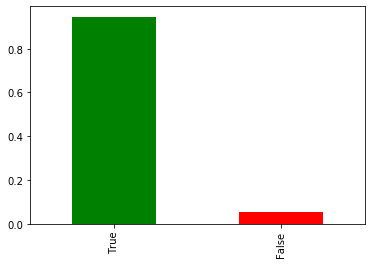

In [37]:
spacex_data['launch_success'].value_counts(normalize=True).plot(kind='bar', color=['g','r'])

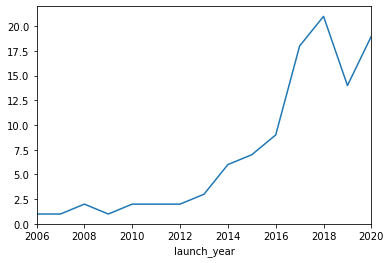

In [49]:
space_date = spacex_data.groupby('launch_year').agg({'flight_number':'count','rocket_second_stage_payloads_0_payload_mass_kg':'mean'})
space_date['flight_number'].plot()

In [50]:
space_date2 = spacex_data.groupby(['launch_year', 'launch_success']).agg({'flight_number':'count','rocket_second_stage_payloads_0_payload_mass_kg':'mean'}).reset_index()
space_date2

,launch_year,launch_success,flight_number,rocket_second_stage_payloads_0_payload_mass_kg
0,2006,False,1,20.000000
1,2007,False,1,NaN
2,2008,False,1,NaN
3,2008,True,1,165.000000
4,2009,True,1,200.000000
5,2010,True,2,NaN
6,2012,True,2,462.500000
7,2013,True,3,1449.000000
8,2014,True,6,3019.333333
9,2015,False,1,2477.000000


In [58]:
launch_failure = pd.pivot_table(space_date2, index='launch_year', columns='launch_success')

launch_failure.fillna(value=0, inplace=True)

launch_failure

flight_number        \
launch_success         False True    
launch_year                          
2006                     1.0   0.0   
2007                     1.0   0.0   
2008                     1.0   1.0   
2009                     0.0   1.0   
2010                     0.0   2.0   
2012                     0.0   2.0   
2013                     0.0   3.0   
2014                     0.0   6.0   
2015                     1.0   6.0   
2016                     1.0   8.0   
2017                     0.0  18.0   
2018                     0.0  21.0   
2019                     0.0  13.0   
2020                     0.0   7.0   

               rocket_second_stage_payloads_0_payload_mass_kg                
launch_success                                          False         True   
launch_year                                                                  
2006                                                     20.0      0.000000  
2007                                                      0.0      0.000000  
2008                                                      0.0    165.000000  
2009                                                      0.0    200.000000  
2010                                                      0.0      0.000000  
2012                                                      0.0    462.500000  
2013                                                      0.0   1449.000000  
2014                                                      0.0   3019.333333  
2015                                                   2477.0   2259.666667  
2016                                                   5500.0   3176.625000  
2017                                                      0.0   5322.235294  
2018                                                      0.0   4394.242500  
2019                                                      0.0   6701.053846  
2020                                                      0.0  13229.500000

In [61]:
launch_failure['flight_number'][1]

launch_year
2006     0.0
2007     0.0
2008     1.0
2009     1.0
2010     2.0
2012     2.0
2013     3.0
2014     6.0
2015     6.0
2016     8.0
2017    18.0
2018    21.0
2019    13.0
2020     7.0
Name: True, dtype: float64

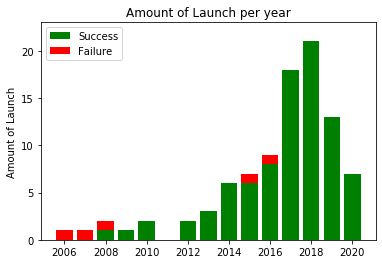

In [71]:
fig, ax = plt.subplots()
ax.bar(launch_failure.index,launch_failure['flight_number'][1], color='g',label='Success')
ax.bar(launch_failure.index,launch_failure['flight_number'][0], color='r', label='Failure',
       bottom=launch_failure['flight_number'][1])
ax.set_ylabel('Amount of Launch')
ax.set_title('Amount of Launch per year')
ax.set_ylim(top=23)
ax.legend()

plt.show()

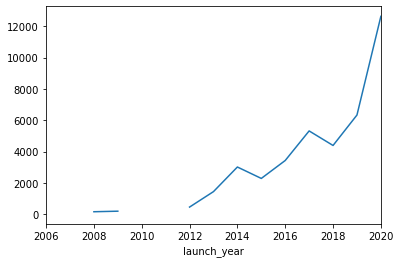

In [27]:
space_date['rocket_second_stage_payloads_0_payload_mass_kg'].plot()

In [28]:
# spacex_data['launch_date'] = pd.to_datetime(spacex_data['launch_date_local'], utc=False)
# # format='%Y-%m-%d')
# # # spacex_data['launch_date'].dt.strftime('%Y-%m-%d')
# # spacex_data['launch_date']

In [29]:
spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'].describe()

count       92.000000
mean      5182.386413
std       4431.759760
min         20.000000
25%       2213.250000
50%       3940.000000
75%       6565.250000
max      15600.000000
Name: rocket_second_stage_payloads_0_payload_mass_kg, dtype: float64

In [30]:
spacex_data[spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'] ==  15600]

,flight_number,mission_name,launch_year,launch_date_unix,launch_date_utc,launch_date_local,tentative_max_precision,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,launch_date,launch_time
83,84,Starlink 1,2019,1573484160,2019-11-11 09:56:00-05:00,2019-11-11T09:56:00-05:00,hour,0.0,falcon9,Falcon 9,FT,B1048,4.0,5.0,True,True,True,True,5.0,Starlink 1,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.100,VLEO,geocentric,very-low-earth,6927.873,0.000145,548.731,550.744,53.0001,95.644,2020-05-27T18:00:00.000Z,15.055766,307.4861,96.2487,79.6518,ccafs_slc_40,CCAFS SLC 40,Cape Canaveral Air Force Station Space Launch ...,True,This mission will launch the first batch of St...,2019-11-11T12:08:00.000Z,1.573474e+09,NaN,44713.0,2019-11-11,09:56:00
88,89,Starlink 3,2020,1580306760,2020-01-29 09:06:00-05:00,2020-01-29T09:06:00-05:00,hour,NaN,falcon9,Falcon 9,FT,B1051,3.0,5.0,True,True,True,True,5.0,Starlink 3,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.113,VLEO,geocentric,very-low-earth,6927.839,0.000198,548.332,551.077,52.9994,95.643,2020-05-27T20:00:01.000Z,15.055876,27.1080,81.6193,270.0790,ccafs_slc_40,CCAFS SLC 40,Cape Canaveral Air Force Station Space Launch ...,True,This mission will launch the third batch of St...,2020-01-20T13:17:00.000Z,1.579526e+09,NaN,45044.0,2020-01-29,09:06:00
91,92,Starlink 5,2020,1584533760,2020-03-18 08:16:00-04:00,2020-03-18T08:16:00-04:00,hour,0.0,falcon9,Falcon 9,FT,B1048,5.0,5.0,True,True,True,True,5.0,Starlink 5,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.113,VLEO,geocentric,very-low-earth,6927.918,0.000150,548.744,550.823,52.9998,95.645,2020-05-27T22:00:00.000Z,15.055618,166.7361,95.2603,117.4581,ksc_lc_39a,KSC LC 39A,Kennedy Space Center Historic Launch Complex 39A,True,The sixth Starlink launch overall and the fift...,2020-03-13T18:37:00.000Z,1.584125e+09,NaN,45178.0,2020-03-18,08:16:00


### API Call Launchpads geolocation

In [31]:
# https://api.spacexdata.com/v3/launchpads/{{site_id}}

# for i in spacex_datea/launch_site_site_id

In [32]:
spacex_data['launch_site_site_id'].unique()

array(['kwajalein_atoll', 'ccafs_slc_40', 'vafb_slc_4e', 'ksc_lc_39a'],
      dtype=object)

In [33]:
spacex_data.launch_site_site_name_long.unique()

array(['Kwajalein Atoll Omelek Island',
       'Cape Canaveral Air Force Station Space Launch Complex 40',
       'Vandenberg Air Force Base Space Launch Complex 4E',
       'Kennedy Space Center Historic Launch Complex 39A'], dtype=object)

In [34]:
launch_responses_list = []

for i in spacex_data['launch_site_site_id'].unique():
    print('The rocket is on the launch pad - API call launchpad data')
    print(f'launchpad API call - requesting {i} data \n')
    
    response = requests.get(f'https://api.spacexdata.com/v3/launchpads/{i}')
    
    if response.status_code != 200:
        print('limit page result reached on page number',page,response.text, '- end of API call')
        break

    #if it's not a cached result, sleep
    if not getattr(response, 'from_cache', False):
        time.sleep(0.35)
    
    #append response list
    launch_responses_list.append(response)
    
print("SpaceX launchpad API call completed")

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting kwajalein_atoll data 

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting ccafs_slc_40 data 

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting vafb_slc_4e data 

The rocket is on the launch pad - API call launchpad data
launchpad API call - requesting ksc_lc_39a data 

SpaceX launchpad API call completed


In [35]:
for i in spacex_data['launch_site_site_id'].unique():
    print(spacex_data['launch_site_site_id'][i])

KeyError: 'kwajalein_atoll'

In [ ]:
launch_responses_list

In [ ]:
#empty list to append all API calls
temp_launch_frame = [] 
for i in range(len(launch_responses_list)):
    r = launch_responses_list[i]    
    flat = flatten_json(r.json())
    temp_launch_frame.append(flat)
    flatten_launch_df = pd.DataFrame(temp_launch_frame)
flatten_launch_df

In [ ]:
spacex_data

In [ ]:
flatten_launch_df[['site_id' ,'location_latitude', 'location_longitude']]

In [ ]:
merged_json = flatten_launch_df[['id','site_id' ,'location_latitude', 'location_longitude']].to_json()

In [ ]:
merged_json

In [ ]:
fig = px.choropleth(data_frame=happiness,
             geojson=merged_json,
              color='happiness-score',
              locations='Country',
              featureidkey="properties.CNTRY_NAME", #location feature's name in the geojson
              projection='orthographic')

# fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
px.choropleth(flatten_launch_df,
             lat='location_latitude',
             lon='location_longitude')

# fig.update_geos(fitbounds="locations", visible=True)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [ ]:
px.choropleth(spacex_data,
             geojson=merged_json,
             locations='launch_site_site_id',
             featureidkey='properties.site_id')

In [ ]:
# spacex_data['launch_date'] = spacex_data['launch_date_local'].astype('datetime64[D]')

### OLD

### for loop to create final df with all calls from appended list

In [ ]:
#empty list to append all API calls
frame = [] 
for i in range(len(responses_list)):
    r = responses_list[i]
    df_temp = pd.DataFrame(json_normalize(r.json()))
    frame.append(df_temp)
df_launch_raw = pd.concat(frame, sort=False)

In [ ]:
r.json()

In [ ]:
print(len(responses_list))

type(responses_list[0])

In [ ]:
df_launch_raw

In [ ]:
df_launch_raw.to_csv('launch_raw.csv', index=False)

### Series of columns to keep

In [ ]:
## dropping links columns

In [ ]:
links = ['links.mission_patch',
       'links.mission_patch_small', 'links.reddit_campaign',
       'links.reddit_launch', 'links.reddit_recovery', 'links.reddit_media',
       'links.presskit', 'links.article_link', 'links.wikipedia',
       'links.video_link', 'links.youtube_id', 'links.flickr_images']

In [ ]:
# df_launch_raw.drop(columns=links, inplace=True)
# df_launch_raw

In [ ]:
Rocket_related = pd.Series(
['rocket_id',
'rocket_name',
'rocket_type',
'second_stage.payloads',
'fairings.reused',
'fairings.recovery_attempt',
'fairings.recovered'])

In [ ]:
rocket = pd.DataFrame(Rocket_related)
rocket

In [ ]:
percent_missing = df_launch_raw.isnull().sum() / len(df_launch_raw) * 100

percent_missing.tail(10)

In [ ]:
missing_value = pd.DataFrame({'column_name': df_launch_raw.columns,
                             'percent_missing':percent_missing})

#filtering to display only columns with 0% missing data = 100% complete columns
missing_value.sort_values(by='percent_missing').head(50)

In [ ]:
kept_columns = missing_value.sort_values(by='percent_missing').head(50).index

kept_columns

In [ ]:
#ditching columns with over 50% null values

In [ ]:
ditch_columns = missing_value[missing_value['percent_missing'] > 50]

ditch_columns

In [ ]:
df_launch_fs = df_launch_raw.drop(columns=ditch_columns.index)

df_launch_fs

In [ ]:
df_launch_fs.info()

In [ ]:
# data conversion
df_launch_fs['launch_success'] = df_launch_fs['launch_success'].astype(bool)
df_launch_fs['launch_date_utc'] = pd.to_datetime(df_launch_fs['launch_date_utc'])

In [ ]:
df_launch_fs['launch_date_utc']

In [ ]:
df_launch_fs['launch_success'].value_counts(normalize=True).plot(kind='bar', color=['g','r'])

In [ ]:
df_launch_fs['launch_date_utc']

In [ ]:
df_launch_fs['launch_date_utc']

In [ ]:
df_launch_group = df_launch_fs.groupby('launch_date_utc').agg('count')

df_launch_group

In [ ]:
df_launch_group['flight_number'].plot()

In [ ]:
df_launch_fs['launch_date_utc'].plot()

In [ ]:
# for column in df_launch_fs.select_dtypes('object'):
# #     print(f'{column:-<70} {df_launch_fs[column].unique()}')

In [ ]:
Launch_related = pd.Series(
['launch_year', 
'launch_date_unix', 
'launch_date_utc',
'crew', 
'ships', 
'launch_success',
'details', 
'launch_site.site_id', 
'launch_site.site_name', 
'launch_site.site_name_long', 
'launch_failure_details.time', 
'launch_failure_details.altitude', 
'launch_failure_details.reason'])

launch = pd.DataFrame(Launch_related)
launch

In [ ]:
spacex_data

In [ ]:
spacex_data['launch_date_utc'].asfreq(freq='m')

In [ ]:
seasonality = sm.tsa.seasonal_decompose(spacex_data['launch_date_utc'], period=50)

seasonality.plot()

In [ ]:
# space2 = spacex_data.set_index('launch_date_local')

In [ ]:
# seasonality = sm.tsa.seasonal_decompose(space2.index, freq=None)

# seasonality.plot()

In [ ]:
space2.index